## Projet Bayésien
Guillaume et Yanis **<3**

## Introduction du problème 

Le problème développé dans ce projet est d'implémenter un échantillonneur selon le modèle statistique donné par le pack de données choisi. 
Nous travaillerons sur le dataset **Eyes**. Il s'agit d'un ensemble de mesures de longueurs d'ondes pour lesquelles les singes qui ont été testés ont une sensibilité maximale. Nos données sont donc en nanomètres.


Ce projet s'articulera en trois mouvements :
- Importation du dataset
- Etude approfondie des modèles statistiques à implémenter
- Implémentation d'un sampler de Gibbs pour la génération d'un échantillon suivant les loi données par le dataset **Eyes**. On implémentera un échantillonneur pour chacun des deux modèles présentés dans le dataset, afin de pouvoir se rendre compte de l'effet d'attraction de classe.

Importation des **Data** :

In [1]:
# Simulation et analyse des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [5]:
# Conversion du fichier eyes.data.R en Python
N = 48
y = np.array([
    529, 530, 532, 533.1, 533.4, 533.6, 533.7, 534.1, 534.8, 535.3,
    535.4, 535.9, 536.1, 536.3, 536.4, 536.6, 537, 537.4, 537.5,
    538.3, 538.5, 538.6, 539.4, 539.6, 540.4, 540.8, 542, 542.8,
    543, 543.5, 543.8, 543.9, 545.3, 546.2, 548.8, 548.7, 548.9,
    549, 549.4, 549.9, 550.6, 551.2, 551.4, 551.5, 551.6, 552.8,
    552.9, 553.2
])
alpha = np.array([1.0, 1.0])

# Conversion du fichier eyes.init.R en Python
lambda_1 = 535
theta = 5
sigmasq = 10
p1 = 0.5


In [6]:
# Création d'un DataFrame pour analyser les données
df1 = pd.DataFrame({'y': y})
print(df1.describe())

                y
count   48.000000
mean   541.533333
std      7.022406
min    529.000000
25%    536.050000
50%    540.000000
75%    548.825000
max    553.200000


Dans l'analyse de l'équipe de Bowmaker et Al., les chercheurs ont retiré 500nm à toutes les valeurs des observations. Nous allons aussi procéder à ce prétraitement.

In [7]:
df = pd.DataFrame({'y': y-500})
print(df.describe()) 

               y
count  48.000000
mean   41.533333
std     7.022406
min    29.000000
25%    36.050000
50%    40.000000
75%    48.825000
max    53.200000


## Etude du modèle statistique non corrigé

DAG + lois conditionnelles (normalement c'est juste une gaussienne classique mais il faut prendre en plus le fait qu'on puisse changer de variable pour le lambda)

Voir rapport

## Implémentation de l'échantillonneur de Gibbs pour le modèle initial

In [9]:
import numpy as np
from scipy.stats import norm, gamma, dirichlet, truncnorm

# Données et hyperparamètres
N = len(y) 
alpha = np.array([1, 1]) # non informatif

# Hyperparamètres pour les priors de lambda_1 et theta
precision_prior = 1.0E-6 

# Initialisations, on essaye d'être le moins informatif possible
lambda1 = np.mean(y)
theta = 1.0
tau = 1.0
P = np.array([0.5, 0.5]) 
T = np.random.choice([1, 2], size=N, p=P) 

n_iter = 5000
# On crée les variables de stockage
samples_lambda1 = np.zeros(n_iter)
samples_theta = np.zeros(n_iter)
samples_tau = np.zeros(n_iter)
samples_P = np.zeros((n_iter, 2))

for it in range(n_iter):
    # Update des T[i]
    for i in range(N):
        # Calculer la densité pour chaque composante
        p1 = P[0] * norm.pdf(y[i], loc=lambda1, scale=1/np.sqrt(tau))
        p2 = P[1] * norm.pdf(y[i], loc=lambda1 + theta, scale=1/np.sqrt(tau))
        prob1 = p1 / (p1 + p2)
        # Tirer T_i
        T[i] = 1 if np.random.rand() < prob1 else 2

    # Comptages
    n1 = np.sum(T == 1)
    n2 = np.sum(T == 2)
    
    # Update de P
    # Dirichlet avec paramètres (alpha1+n1, alpha2+n2)
    P = dirichlet.rvs(alpha + np.array([n1, n2]))[0]
    
    # Update de tau
    # Calcul de la somme des carrés des résidus
    resid = np.array([y[i] - (lambda1 if T[i]==1 else lambda1+theta) for i in range(N)])
    S = np.sum(resid**2)
    tau = gamma.rvs(0.001 + N/2, scale=1.0/(0.001 + S/2))
    
    # Update de lambda_1
    # Sums selon les groupes
    S1 = np.sum(y[T == 1])
    S2 = np.sum(y[T == 2] - theta)
    var_lambda1 = 1.0 / (tau * (n1 + n2) + precision_prior)
    mu_lambda1  = var_lambda1 * tau * (S1 + S2)
    lambda1 = norm.rvs(loc=mu_lambda1, scale=np.sqrt(var_lambda1))
    
    # Update de theta
    # Pour theta, seules les observations du groupe 2 interviennent
    if n2 > 0:
        S2_prime = np.sum(y[T == 2] - lambda1)
        var_theta = 1.0 / (tau * n2 + precision_prior)
        mu_theta  = var_theta * tau * S2_prime
        # Échantillonnage de theta à partir d'une normale tronquée à (0, inf)
        a, b = (0 - mu_theta) / np.sqrt(var_theta), np.inf
        theta = truncnorm.rvs(a, b, loc=mu_theta, scale=np.sqrt(var_theta))
    else:
        # Si aucun y n'est assigné à 2, on choisit de garder la valeur précédente
        theta = theta

    # Stockage des échantillons
    samples_lambda1[it] = lambda1
    samples_theta[it] = theta
    samples_tau[it] = tau
    samples_P[it, :] = P


Text(0, 0.5, 'Theta')

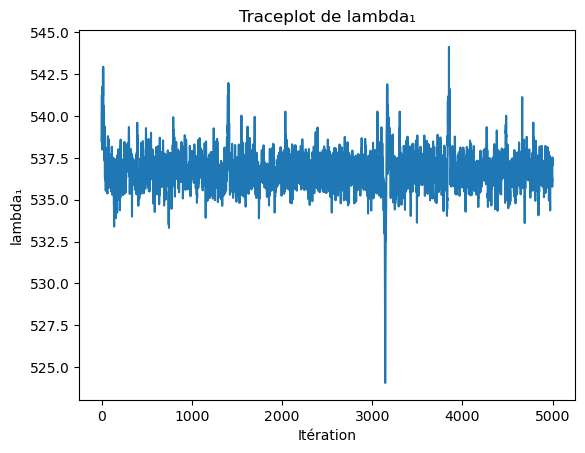

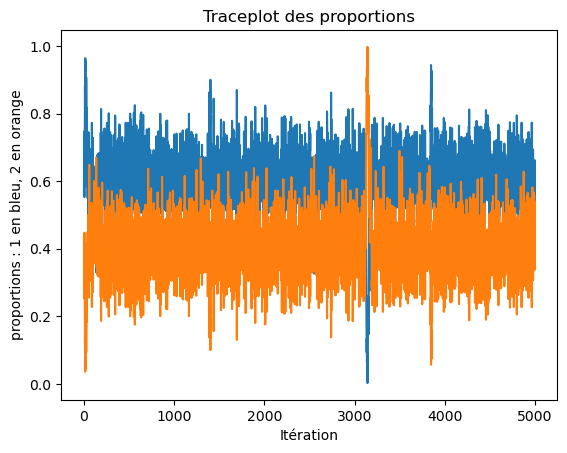

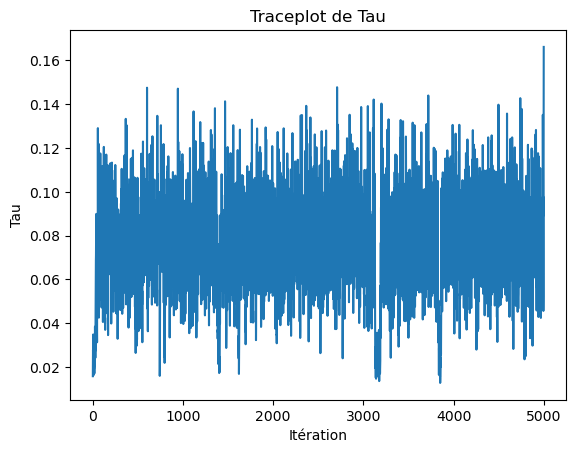

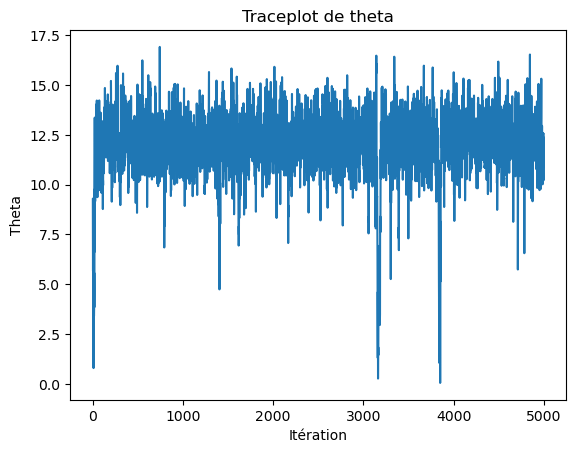

In [22]:
plt.plot(samples_lambda1)
plt.title("Traceplot de lambda₁")
plt.xlabel("Itération")
plt.ylabel("lambda₁")
plt.figure()
plt.plot(samples_P)
plt.title("Traceplot des proportions")
plt.xlabel("Itération")
plt.ylabel("proportions : 1 en bleu, 2 en orange")
plt.figure()
plt.plot(samples_tau)
plt.title("Traceplot de Tau")
plt.xlabel("Itération")
plt.ylabel("Tau")
plt.figure()
plt.plot(samples_theta)
plt.title("Traceplot de theta")
plt.xlabel("Itération")
plt.ylabel("Theta")

Le deuxieme graphique (proportions) est convenable. 

## Etude du modèle statistique corrigé

## Implémentation de la correction :
$\lambda_2 = \lambda_1 + \theta$  avec $\theta > 0$

on fait attention au label switching à la fin de chaque itération.

In [ ]:
import numpy as np
from scipy.stats import norm, gamma, dirichlet, truncnorm

# Données et hyperparamètres
N = len(y)
alpha = np.array([1, 1])  # prior non informatif

# Hyperparamètres pour les priors de lambda_1 et theta
precision_prior = 1.0E-6  # variance de 1e6

# Initialisations
lambda1 = np.mean(y)
theta = 1.0
tau = 1.0
P = np.array([0.5, 0.5])
T = np.random.choice([1, 2], size=N, p=P)

n_iter = 5000

# Stockage
samples_lambda1 = np.zeros(n_iter)
samples_theta = np.zeros(n_iter)
samples_tau = np.zeros(n_iter)
samples_P = np.zeros((n_iter, 2))

# Gibbs sampler avec ordre imposé lambda1 < lambda2
for it in range(n_iter):
    # Update des T[i]
    for i in range(N):
        p1 = P[0] * norm.pdf(y[i], loc=lambda1, scale=1 / np.sqrt(tau))
        p2 = P[1] * norm.pdf(y[i], loc=lambda1 + theta, scale=1 / np.sqrt(tau))
        prob1 = p1 / (p1 + p2)
        T[i] = 1 if np.random.rand() < prob1 else 2

    # Comptage des groupes
    n1 = np.sum(T == 1)
    n2 = N - n1

    # Update de P
    P = dirichlet.rvs(alpha + np.array([n1, n2]))[0]

    # Update de tau
    resid = np.array([y[i] - (lambda1 if T[i] == 1 else lambda1 + theta) for i in range(N)])
    S = np.sum(resid**2)
    tau = gamma.rvs(0.001 + N / 2, scale=1.0 / (0.001 + S / 2))

    # Update de lambda_1
    S1 = np.sum(y[T == 1])
    S2 = np.sum(y[T == 2] - theta)
    var_lambda1 = 1.0 / (tau * (n1 + n2) + precision_prior)
    mu_lambda1 = var_lambda1 * tau * (S1 + S2)
    lambda1 = norm.rvs(loc=mu_lambda1, scale=np.sqrt(var_lambda1))

    # Update de theta (normal tronquée à (0, ∞))
    if n2 > 0:
        S2_prime = np.sum(y[T == 2] - lambda1)
        var_theta = 1.0 / (tau * n2 + precision_prior)
        mu_theta = var_theta * tau * S2_prime
        a, b = (0 - mu_theta) / np.sqrt(var_theta), np.inf
        theta = truncnorm.rvs(a, b, loc=mu_theta, scale=np.sqrt(var_theta))
    else:
        theta = theta  # inchangé

    lambda2 = lambda1 + theta
    if lambda1 > lambda2:
        lambda1 = lambda2
        theta = np.abs(-theta)  # devient positif à nouveau
        T = 3 - T               # on permute les labels
        P = P[::-1]             # on permute les proportions


    # Stockage
    samples_lambda1[it] = lambda1
    samples_theta[it] = theta
    samples_tau[it] = tau
    samples_P[it, :] = P


1min20 pour run le code... Zzzzz On aurait dû faire du R

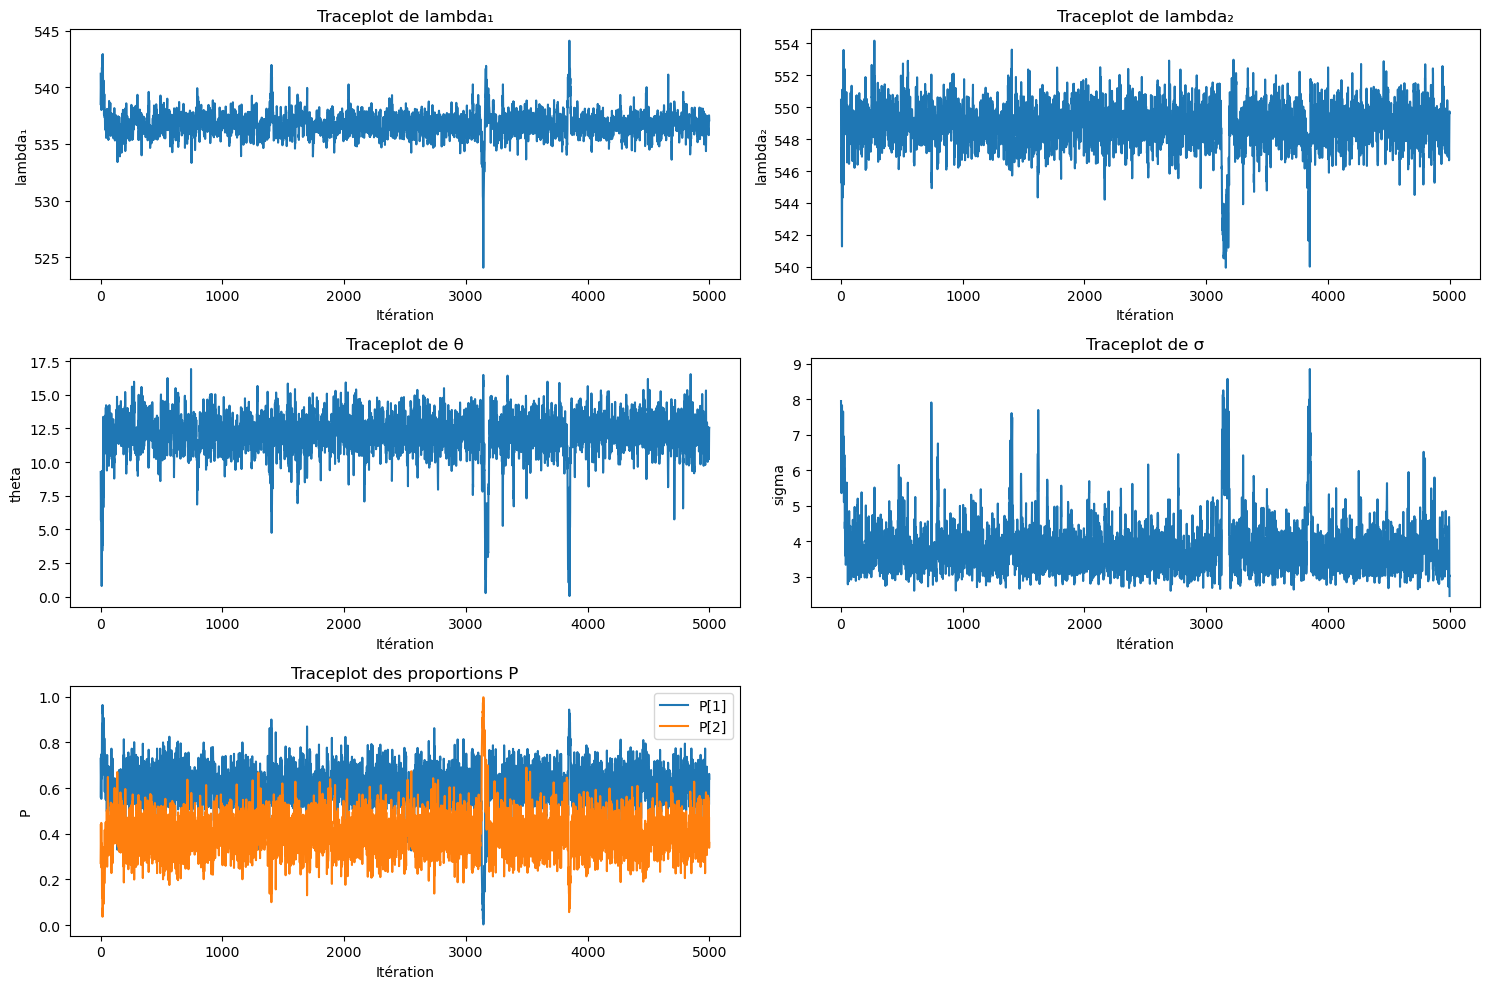

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de lambda2 et sigma
samples_lambda2 = samples_lambda1 + samples_theta
samples_sigma = 1 / np.sqrt(samples_tau)

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.plot(samples_lambda1)
plt.title("Traceplot de lambda₁")
plt.xlabel("Itération")
plt.ylabel("lambda₁")

plt.subplot(3, 2, 2)
plt.plot(samples_lambda2)
plt.title("Traceplot de lambda₂")
plt.xlabel("Itération")
plt.ylabel("lambda₂")

plt.subplot(3, 2, 3)
plt.plot(samples_theta)
plt.title("Traceplot de θ")
plt.xlabel("Itération")
plt.ylabel("theta")

plt.subplot(3, 2, 4)
plt.plot(samples_sigma)
plt.title("Traceplot de σ")
plt.xlabel("Itération")
plt.ylabel("sigma")

plt.subplot(3, 2, 5)
plt.plot(samples_P[:, 0], label="P[1]")
plt.plot(samples_P[:, 1], label="P[2]")
plt.title("Traceplot des proportions P")
plt.xlabel("Itération")
plt.ylabel("P")
plt.legend()

plt.tight_layout()
plt.show()


Les traceplots montrent une stabilisation rapide des chaînes après environ 500 itérations, indiquant une bonne convergence.

λ₁ oscille autour de 536, avec une fluctuation modérée : cela correspond à la moyenne du premier groupe.

λ₂ (déduit de λ₁ + θ) est bien séparé, centré autour de 549, ce qui valide la présence de deux composantes distinctes.

θ fluctue de manière régulière autour de 12–13, indiquant une distance stable entre les deux composantes.

σ (écart-type commun) montre une variabilité initiale mais se stabilise rapidement autour de 4–5.

Les proportions P[1] et P[2] ne subissent plus de saut brutal ni de domination complète d’un groupe, ce qui confirme que le label switching est résolu.

On peut conclure que le modèle bayésien avec contrainte fournit une séparation claire et identifiée entre deux sous-populations de longueurs d’onde, sans ambiguïté de regroupement.

### Bonus densités

Text(0.5, 0, 'Valeur')

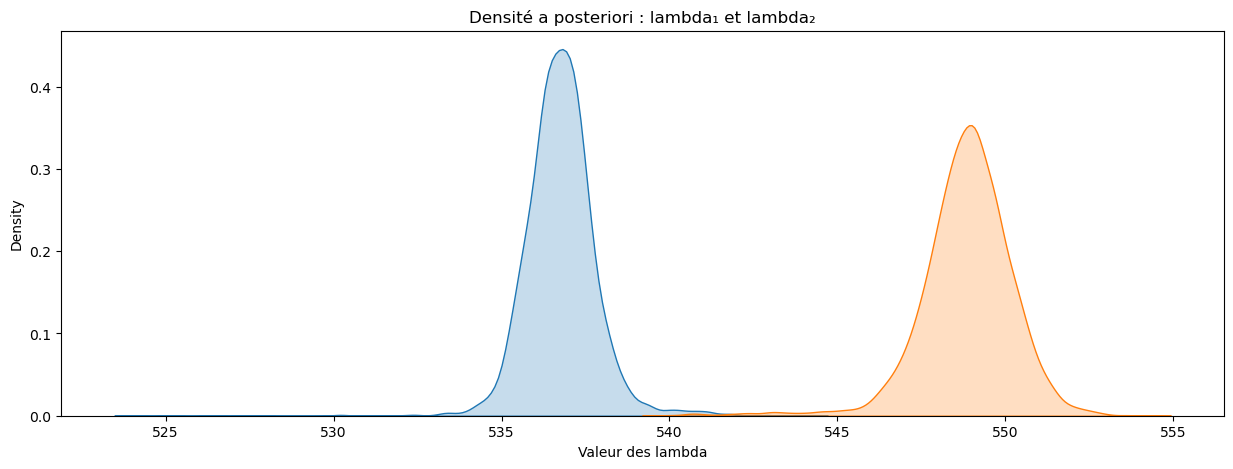

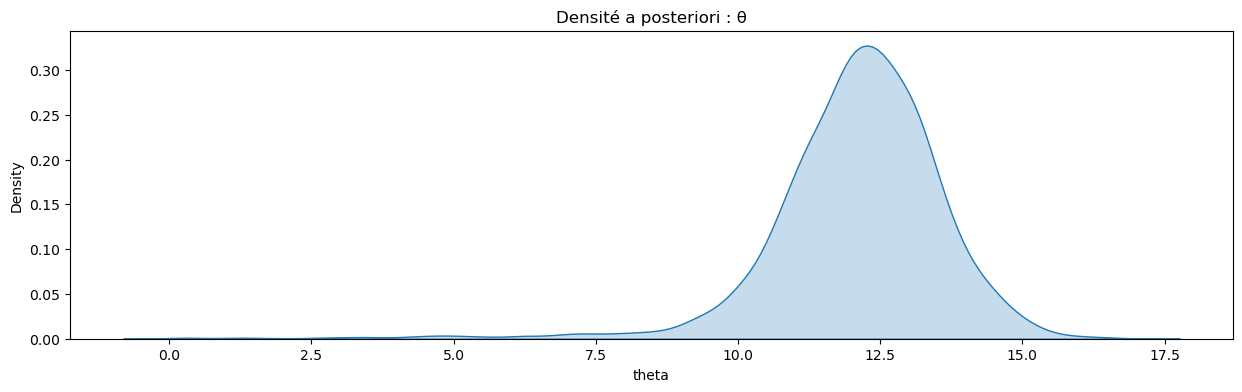

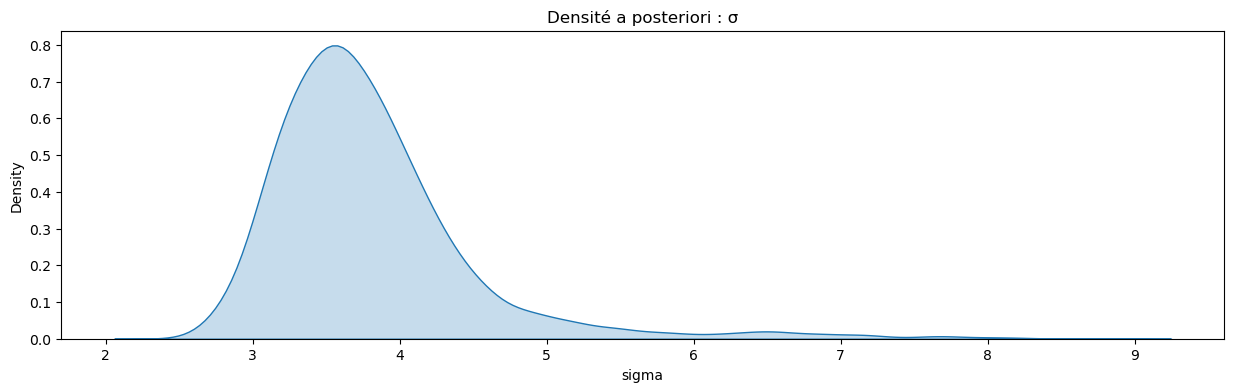

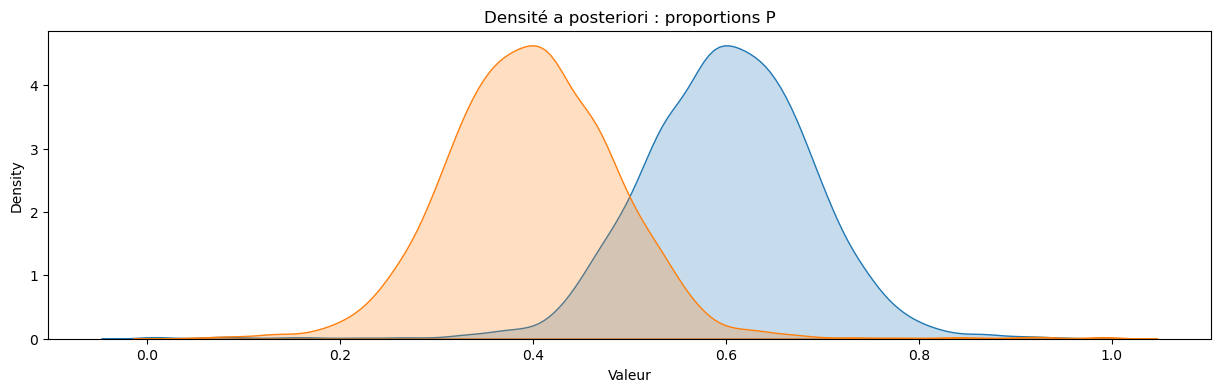

In [26]:
plt.figure(figsize=(15, 5))
sns.kdeplot(samples_lambda1, fill=True, label="lambda₁")
sns.kdeplot(samples_lambda2, fill=True, label="lambda₂")
plt.title("Densité a posteriori : lambda₁ et lambda₂")
plt.xlabel("Valeur des lambda")

plt.figure(figsize=(15, 4))
sns.kdeplot(samples_theta, fill=True)
plt.title("Densité a posteriori : θ")
plt.xlabel("theta")


plt.figure(figsize=(15, 4))
sns.kdeplot(samples_sigma, fill=True)
plt.title("Densité a posteriori : σ")
plt.xlabel("sigma")


plt.figure(figsize=(15, 4))
sns.kdeplot(samples_P[:, 0], fill=True, label="P[1]")
sns.kdeplot(samples_P[:, 1], fill=True, label="P[2]")
plt.title("Densité a posteriori : proportions P")
plt.xlabel("Valeur")



###  Analyse des densités a posteriori

#### lambda₁ et lambda₂
Même conclusion que sur le graphique précédent : 
- On observe **deux pics bien distincts**, centrés autour de **537** et **549**.
- Cela confirme la présence de **deux composantes gaussiennes clairement séparées**, validant la pertinence du modèle de mélange.

#### Theta

- La densité de $\theta$ est **centrée autour de 12.5**, avec une concentration marquée ; cela reflète une **distance stable entre les deux composantes**, ce qui est utile pour identifier les lambdas.

#### Sigma
- Le pic est centré autour de **3.7**, ce qui reflète une **variabilité intra-groupe raisonnable** vis a vis de l'écart de 12.5 entre les groupes.
- La queue droite traduit une légère incertitude sur la dispersion de certaines observations, mais globalement la variance est bien contrôlée.

#### P (proportions des deux groupes)
- P[1] est centré autour de **0.6**, P[2] autour de **0.4**, suggérant une **répartition asymétrique mais nette** entre les deux groupes.
- Les densités ne se superposent pas, ce qui indique que le modèle **attribue clairement les observations** à une composante ou l’autre, sans ambiguïté.



### Conclusion

Ce modèle bayésien avec contrainte lambda₂ = lambda₁ + θ fournit une estimation stable et cohérente des deux groupes en identifiant bien la distance (θ) entre lambda1 et lambda2.
**Les paramètres convergent proprement et décrivent fidèlement la structure bimodale des données.**